## Project aim : Predicting the medical condition using using webMD drug reviews dataset.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist, bigrams
from nltk import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob
from spellchecker import SpellChecker
import string
import unicodedata
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [2]:
## Reading the dataset into pandas dataframe
data = pd.read_csv("Reviews/webmd.csv")

## Displaying the first 5 rows of data
data.head(5)

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1


In [3]:
# replacing Attention Deficit Disorder with Hyperactivity with ADHD

data.Condition.replace('Attention Deficit Disorder with Hyperactivity','ADHD',inplace=True)

In [4]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in the dataset ")

There are 362806 rows and 12 columns in the dataset 


In [5]:
## printing the summary of the dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB
None


**Observations** : <br>
There are 2 datatypes: numerical and object <br>

- The date column is also represented as object column.
- Reviews column has missing values.

In [6]:
# Finding the number of missing values in Reviews column
print(f" The number of rows data is missing in reviews column: {data.Reviews.isnull().sum()}")

 The number of rows data is missing in reviews column: 37


### Exploratory Data Analysis (EDA) 

In [7]:
# findings the rows where review is missing 
missing_row_indices = np.where(data.Reviews.isnull())
missing_row_indices

(array([ 13890,  14103,  14677,  18370,  72262,  73924,  75402,  77417,
         77430,  77455,  77484,  77815, 110318, 113773, 133161, 156236,
        158790, 160359, 160997, 168734, 183153, 228856, 229387, 241391,
        274503, 284752, 287349, 295174, 297321, 297362, 297622, 299925,
        323283, 323320, 347449, 347671, 352458], dtype=int64),)

In [8]:
data.loc[missing_row_indices]

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
13890,55-64,High Blood Pressure,10/28/2008,lisinopril solution,6873,3,3,NaN,3,Female,"Dizziness , lightheadedness , tiredness, or headache may occur as your body adjusts to the medication . Dry cough may also occur.",1
14103,45-54,High Blood Pressure,8/9/2011,lisinopril solution,6873,5,1,NaN,1,Male,"Dizziness , lightheadedness , tiredness, or headache may occur as your body adjusts to the medication . Dry cough may also occur.",0
14677,45-54,High Blood Pressure,8/9/2011,lisinopril,6873,5,1,NaN,1,Male,"Dizziness , lightheadedness , tiredness, or headache may occur as your body adjusts to the medication . Dry cough may also occur.",0
18370,55-64,High Blood Pressure,10/28/2008,lisinopril,6873,3,3,NaN,3,Female,"Dizziness , lightheadedness , tiredness, or headache may occur as your body adjusts to the medication . Dry cough may also occur.",1
72262,45-54,Prevent Radiation-Induced Nausea and Vomiting,6/10/2013,ondansetron odt,16910,5,5,NaN,5,Female,"Headache , lightheadedness , dizziness , drowsiness, tiredness, or constipation may occur.",0
73924,45-54,Prevent Radiation-Induced Nausea and Vomiting,6/10/2013,ondansetron film,16910,5,5,NaN,5,Female,"Headache , lightheadedness , dizziness , drowsiness, tiredness, or constipation may occur.",0
75402,25-34,Pain,11/12/2010,morphine sulfate syringe,3891,3,3,NaN,3,,"Nausea , vomiting , constipation , lightheadedness , dizziness , drowsiness, increased sweating , or dry mouth may occur.",2
77417,25-34,Pain,8/10/2010,morphine sulfate er,327,4,5,NaN,5,Female,"Nausea , vomiting , constipation , lightheadedness , dizziness , or drowsiness may occur.",0
77430,25-34,Pain,8/10/2010,"morphine sulfate er capsule, extended release multiphase 24 hr",327,4,5,NaN,5,Female,"Nausea , vomiting , constipation , lightheadedness , dizziness , or drowsiness may occur.",0
77455,25-34,Pain,8/10/2010,"morphine tablet,oral only, extended release",327,4,5,NaN,5,Female,"Nausea , vomiting , constipation , sweating , lightheadedness , dizziness , or drowsiness may occur.",0


#### Upon closure inspection of data it is found that, in many rows in object columns such as age, reviews, condition, reviews, sex and sides the missing data is represented as an empty string.

In [9]:
## Replacing empty strings with NaN
data = data.replace(' ',np.NaN)

In [10]:
data.isnull().sum()

Age              12202
Condition        43   
Date             0    
Drug             0    
DrugId           0    
EaseofUse        0    
Effectiveness    0    
Reviews          41861
Satisfaction     0    
Sex              26537
Sides            17460
UsefulCount      0    
dtype: int64

<AxesSubplot:>

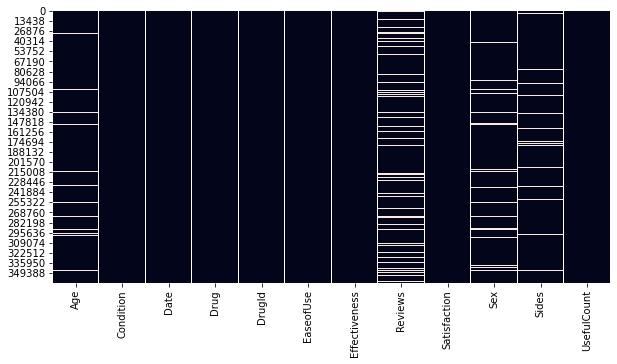

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False)

In [12]:
print(f"Number of rows with empty review : {len(data[data.Reviews==' '])}")

Number of rows with empty review : 0


In [13]:
print(f"Total number of drugs for which reviews are missing : {data.Reviews.isnull().sum()}")

Total number of drugs for which reviews are missing : 41861


#### Since review is the most important column using which we are trying to predict the medical condition, dropping the rows where review is missing.

In [14]:
data = data.dropna(axis=0, subset=['Reviews'])
print(f"Length of dataset after dropping null values in reviews column : {len(data)}")

Length of dataset after dropping null values in reviews column : 320945


### On WebMd the satisfaction and effectiveness are in range from 1 to 5 but for some rows, these values are above this range, this might have arisen due to data collection errors

In [15]:
print(data.Satisfaction.unique())
print(data.Effectiveness.unique())

[ 5  3  1  4  2  6 10]
[ 5  3  2  1  4  6 10]


In [16]:
data[(data.Satisfaction>5) | (data.Effectiveness>5)]

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
195073,35-44,Migraine Prevention,5/18/2009,"topamax capsule, sprinkle",14494,6,6,ahoj som zo slovenska dlhe roky mam migreny tu som našla tento liek ešte len ho skušam zatial sa citim dobre ale zaujimalo by ma aku davku by som mala brat pri vahe 86 kg teraz mam len 25mg/denne aby som aj schudla???rada by som mala aj takýto vedlajší úcinok..a dakde som cítala že viacerým z tohto lieku vypadávaliu vlasy???je to pravda??dik,6,Female,"Tiredness, drowsiness, dizziness , loss of coordination, tingling of the hands/feet, loss of appetite, bad taste in your mouth , diarrhea , and weight loss may occur.",0
195282,35-44,Migraine Prevention,5/18/2009,topamax,14494,6,6,ahoj som zo slovenska dlhe roky mam migreny tu som našla tento liek ešte len ho skušam zatial sa citim dobre ale zaujimalo by ma aku davku by som mala brat pri vahe 86 kg teraz mam len 25mg/denne aby som aj schudla???rada by som mala aj takýto vedlajší úcinok..a dakde som cítala že viacerým z tohto lieku vypadávaliu vlasy???je to pravda??dik,6,Female,"Tiredness, drowsiness, dizziness , loss of coordination, tingling of the hands/feet, loss of appetite, bad taste in your mouth , diarrhea , and weight loss may occur.",0
273577,45-54,Other,6/12/2013,fiorinal with codeine #3,2421,10,10,.,10,NaN,"Nausea , vomiting , stomach upset, gas, shaking (tremor), constipation , dry mouth , lightheadedness , dizziness , drowsiness, or trouble sleeping may occur.",5


In [17]:
# dropping rows where the Satisfaction and Effectiveness of drug is <= 5
data.drop(data[data.Satisfaction>5].index,inplace=True)
print(data.Satisfaction.unique())
print(data.Effectiveness.unique())

[5 3 1 4 2]
[5 3 2 1 4]


## Checking for the number of Unique conditions present in the data

In [99]:
print("Total number of unique conditions present in the given data: {} ".format(data.Condition.nunique()))

Total number of unique conditions present in the given data: 1733 


#### Top 10 medical conditions:

In [100]:
print(data.Condition.value_counts(ascending=False)[:10])

Other                       45768
Pain                        20378
High Blood Pressure         19411
Depression                  12697
Birth Control               11941
Neuropathic Pain            7604 
Chronic Trouble Sleeping    6516 
Type 2 Diabetes Mellitus    6366 
ADHD                        6015 
Bipolar Depression          5260 
Name: Condition, dtype: int64


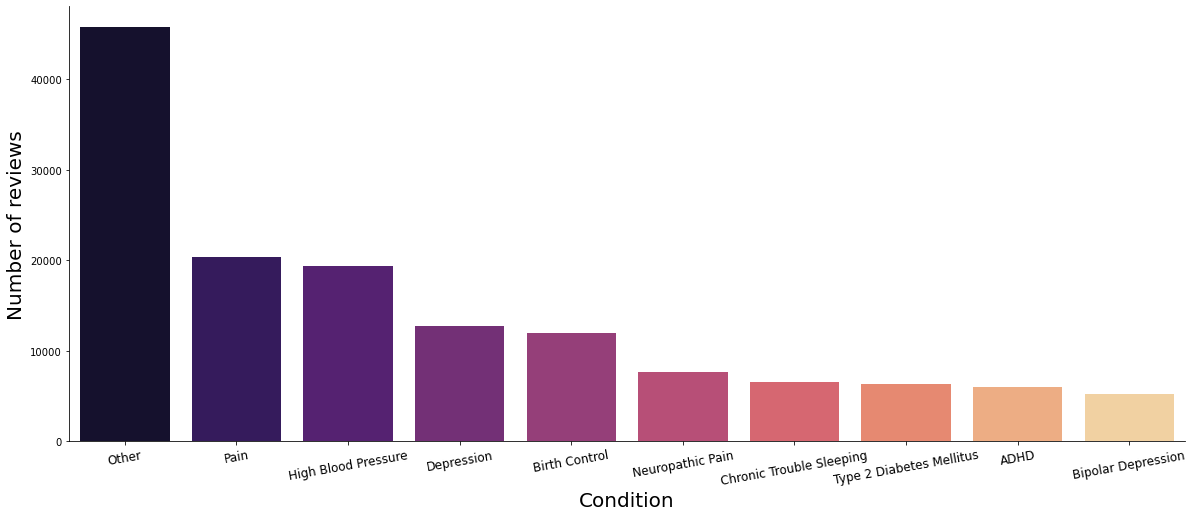

In [101]:
plt.figure(figsize=(20,8))
plt.xticks(fontsize=12 ,rotation=10)

top10_conditions = data.Condition.value_counts(ascending=False)[:10].index
counts =  data.Condition.value_counts(ascending=False)[:10].values
sns.barplot(x=top10_conditions, y=counts,palette='magma')
sns.despine()
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
#y_axis.set_visible(False)
#plt.title('Top 10 Conditions',fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('Number of reviews',fontsize=20)
plt.show()


**Observations:**
- There are 1733 unique medical conditions.
- There are 45768 rows, where the condition name is not mentioned instead it is mentioned as other.
- Majority people wrote reviews about pain, high blood pressure, depression, birth control, trouble sleeping, diabetes.

## Checking for the number of Unique Drugs present in the data

In [102]:
print(f"Number of unique drugs present in the dataset : {data.Drug.nunique()}")

Number of unique drugs present in the dataset : 6630


#### Top 10 Drugs:

In [179]:
print(data.Drug.value_counts(ascending=False)[:10])

cymbalta                     4146
lexapro                      3565
lisinopril                   3486
lisinopril solution          3486
effexor xr                   3086
hydrocodone-acetaminophen    2974
lyrica                       2778
tramadol hcl                 2519
tramadol hcl er              2519
zoloft                       2309
Name: Drug, dtype: int64


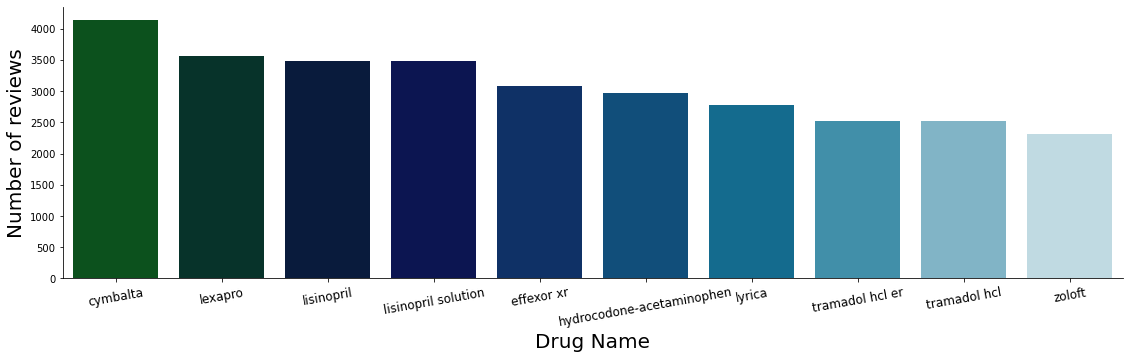

In [330]:
plt.figure(figsize=(19,5))
plt.xticks(fontsize=12 ,rotation=10)

top10_drugnames = data.Drug.value_counts(ascending=False)[:10].index
counts =  data.Drug.value_counts(ascending=False)[:10].values
sns.barplot(x=top10_drugnames, y=counts,palette='ocean')
sns.despine()
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
#y_axis.set_visible(False)
#plt.title('Top 10 Drugs',fontsize=20)
plt.xlabel('Drug Name',fontsize=20)
plt.ylabel('Number of reviews',fontsize=20)
plt.show()

## Number of drugs per condition

In [105]:
drugs_per_condition = data.groupby("Condition")["Drug"].nunique().sort_values(ascending=False)[:10]
drugs_per_condition

Condition
Other                                         4201
Osteoporosis                                  227 
Birth Control                                 200 
High Blood Pressure                           196 
Acne                                          191 
Pain                                          188 
Painful Periods                               158 
Rheumatoid Arthritis                          136 
Cough                                         126 
Inflammation of the Nose due to an Allergy    116 
Name: Drug, dtype: int64

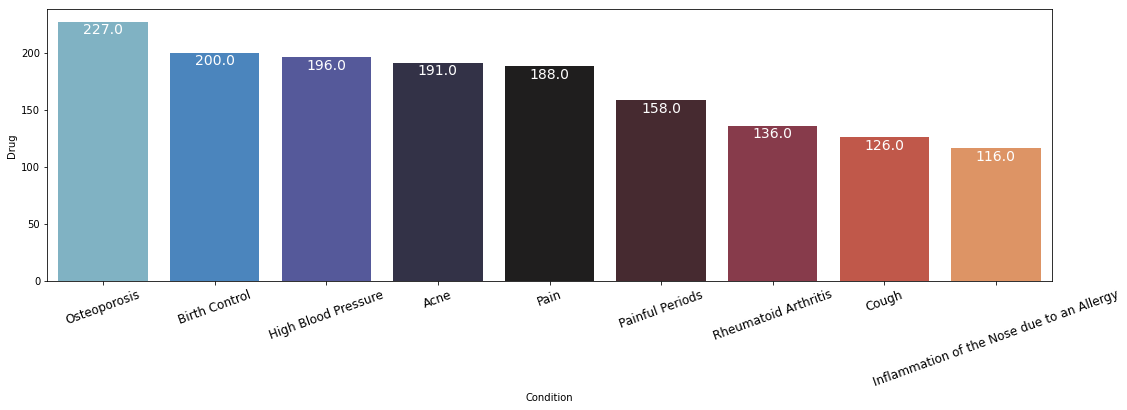

In [107]:
plt.figure(figsize=(18,5))
plt.xticks(fontsize=12 ,rotation=20)

top10_drugnames = data.groupby("Condition")["Drug"].nunique().sort_values(ascending=False)[1:10].index
counts =  data.groupby("Condition")["Drug"].nunique().sort_values(ascending=False)[1:10]
ax = sns.barplot(x=top10_drugnames, y=counts,palette='icefire')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), 
                ha='center',
                va='center',
                color='white',
                size=14)

## Visualizing numerical features

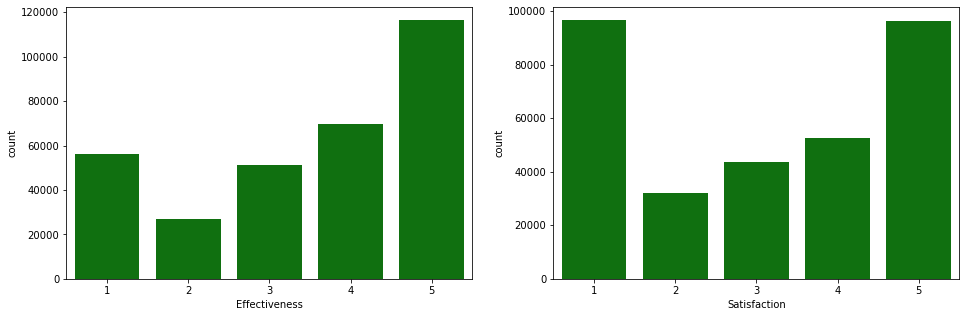

In [114]:
## Visualizing numeric features : using seaborn distribution plot to see data distribution in each feature
numeric_features = ['Effectiveness', 'Satisfaction']

plt.figure(figsize=(16,5))
plt_number = 1

for column_name in numeric_features:
    if plt_number <= 4:
        ax = plt.subplot(1,2,plt_number)
        effectiveness = data[column_name].value_counts().index
        counts =  data[column_name].value_counts().values
        #print(effectiveness,counts)
        sns.barplot(x=effectiveness,y=counts,color='green')
        plt.xlabel(column_name)
        plt.ylabel('count')
    plt_number+=1

- Both in terms of effectiveness and satisfaction, users opinions seems to be extreme, they either rated a drug low or high.

# Selecting High BP, depression, birth control, diabetes conditons & creating data frame with data filtered

In [18]:
disease_df = data[(data['Condition']=='High Blood Pressure') | (data['Condition']=='Depression')| (data['Condition']=='Birth Control') | (data['Condition']=='Type 2 Diabetes Mellitus')]
disease_df.shape

(50415, 12)

In [118]:
disease_df.Condition.unique()

array(['Birth Control', 'High Blood Pressure', 'Type 2 Diabetes Mellitus',
       'Depression'], dtype=object)

## Data distribution in each class

In [119]:
disease_df.Condition.value_counts(normalize=True)

High Blood Pressure         0.385024
Depression                  0.251850
Birth Control               0.236854
Type 2 Diabetes Mellitus    0.126272
Name: Condition, dtype: float64

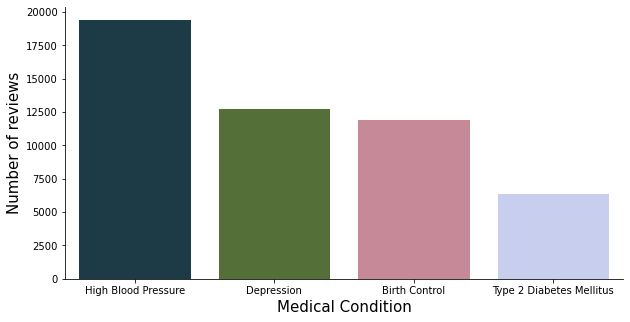

In [331]:
plt.figure(figsize=(10,5))
#plt.title('Data distribution in each class')
plt.xlabel('Medical Condition',size=15)
plt.ylabel('Number of reviews',size=15)
sns.barplot(x=disease_df.Condition.value_counts().index,
            y=disease_df.Condition.value_counts().values,
            palette='cubehelix')
sns.despine()

In [121]:
disease_df.groupby("Condition")["Drug"].nunique().sort_values(ascending=False)

Condition
Birth Control               200
High Blood Pressure         196
Type 2 Diabetes Mellitus    111
Depression                  69 
Name: Drug, dtype: int64

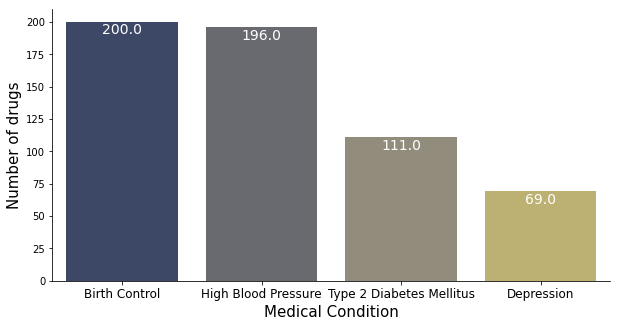

In [335]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=12)
#plt.title('Number of drugs for each condition',fontsize=15)

top4_conditions = disease_df.groupby("Condition")["Drug"].nunique().sort_values(ascending=False).index
counts =  disease_df.groupby("Condition")["Drug"].nunique().sort_values(ascending=False).values
ax = sns.barplot(x=top4_conditions, y=counts,palette='cividis')
sns.despine()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), 
                ha='center',
                va='center',
                color='white',
                size=14)
plt.xlabel('Medical Condition',size=15)
plt.ylabel('Number of drugs',size=15)
plt.show()

## Analyzing individual condition

In [126]:
birth_control = disease_df[disease_df['Condition']=='Birth Control']
hyper_tension = disease_df[disease_df['Condition']=='High Blood Pressure']
depression = disease_df[disease_df['Condition']=='Depression']
diabetes   = disease_df[disease_df['Condition']=='Type 2 Diabetes Mellitus']

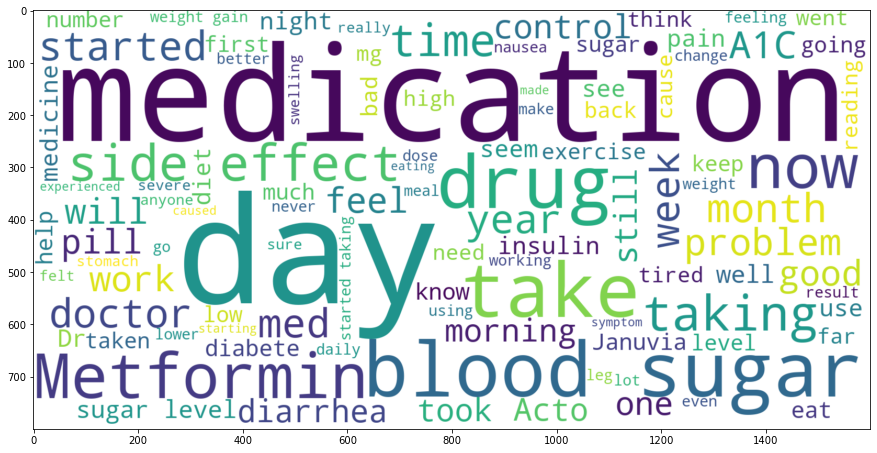

In [127]:
plt.figure(figsize=(15,20))
stop_words = set(STOPWORDS)
cloud = WordCloud(max_words = 100, 
                  width=1600, 
                  height=800,
                  stopwords=stop_words,
                  background_color='white').generate(" ".join(diabetes['Reviews']))
plt.imshow(cloud, interpolation='bilinear')
#plt.title('Diabetes',fontsize=14)

Text(0.5, 1.0, 'Birth control word cloud')

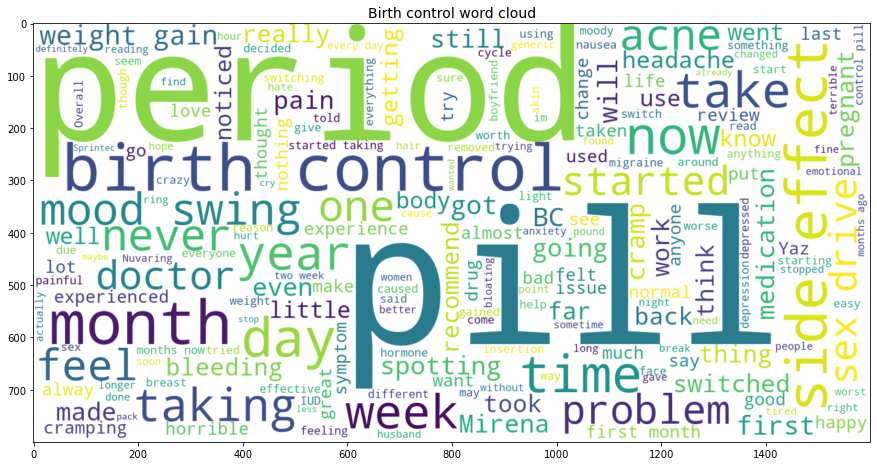

In [325]:
plt.figure(figsize=(15,20))
stop_words = set(STOPWORDS)
cloud = WordCloud(max_words = 200, 
                  width=1600, 
                  height=800,
                  stopwords=stop_words,
                  background_color='white').generate(" ".join(birth_control['Reviews']))
plt.imshow(cloud, interpolation='bilinear')
plt.title('Birth control word cloud',fontsize=14)

Text(0.5, 1.0, 'Hypertension word cloud')

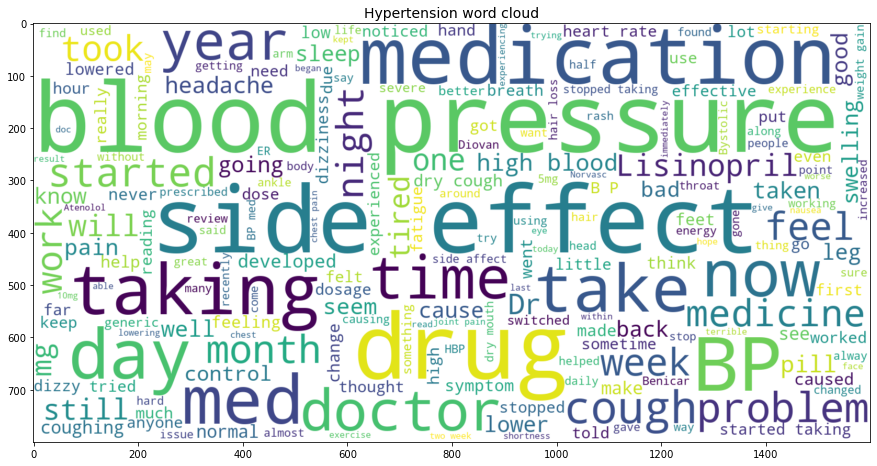

In [326]:
plt.figure(figsize=(15,20))
stop_words = set(STOPWORDS)
cloud = WordCloud(max_words = 200, 
                  width=1600, 
                  height=800,
                  stopwords=stop_words,
                  background_color='white').generate(" ".join(hyper_tension['Reviews']))
plt.imshow(cloud, interpolation='bilinear')
plt.title('Hypertension word cloud',fontsize=14)

Text(0.5, 1.0, 'Depression word cloud')

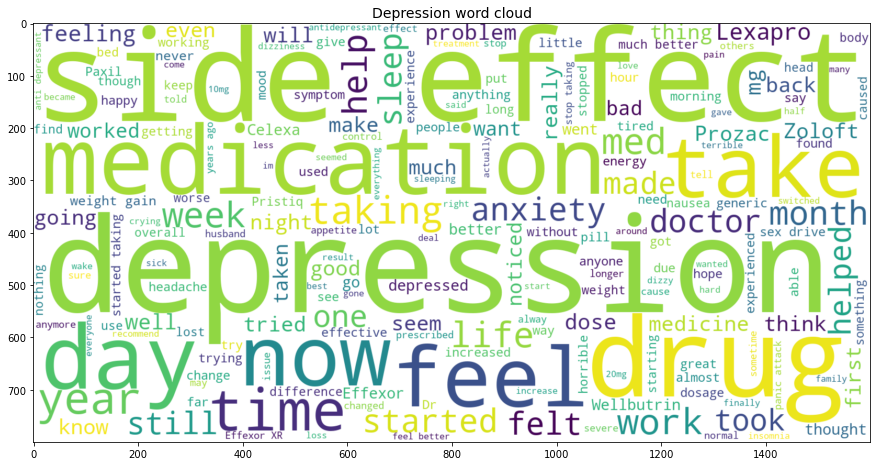

In [327]:
plt.figure(figsize=(15,20))
stop_words = set(STOPWORDS)
cloud = WordCloud(max_words = 200, 
                  width=1600, 
                  height=800,
                  stopwords=stop_words,
                  background_color='white').generate(" ".join(depression['Reviews']))
plt.imshow(cloud, interpolation='bilinear')
plt.title('Depression word cloud',fontsize=14)

Text(0.5, 1.0, 'Diabetes word cloud')

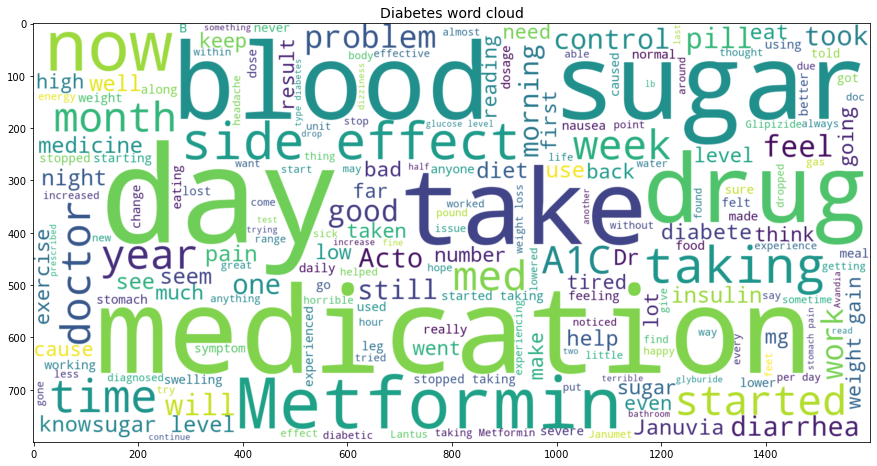

In [328]:
plt.figure(figsize=(15,20))
stop_words = set(STOPWORDS)
cloud = WordCloud(max_words = 200, 
                  width=1600, 
                  height=800,
                  stopwords=stop_words,
                  background_color='white').generate(" ".join(diabetes['Reviews']))
plt.imshow(cloud, interpolation='bilinear')
plt.title('Diabetes word cloud',fontsize=14)

In [131]:
drug_dict={}
for drug_id,name in disease_df[['DrugId','Drug']].itertuples(index=False): #Iterate over DataFrame rows as namedtuples.
    drug_dict.setdefault(drug_id, set()).add(name)
drug_dict = {k:list(v) for k,v in drug_dict.items()}

drugs_with_morethan_onename = {k:list(v) for k,v in drug_dict.items() if len(v) > 1}
drugs_with_morethan_onename

for x in list(drugs_with_morethan_onename):
    print (x,  drugs_with_morethan_onename[x])
    
# print(len(drugs_with_morethan_onename))

6873 ['lisinopril solution', 'lisinopril']
159426 ['linagliptin-metformin tablet, immediate release and extended release, biphasic 24hr (tablet,immed & ext release,biphasic 24hr)', 'linagliptin-metformin tablet']
1058 ['levonorgestrel-eth estradiol tablet contraceptives', 'levonorgestrel-eth estradiol', 'levonorgestrel-eth estradiol tablet, dose pack, 3 months contraceptives']
20417 ['levonorgestrel intrauterine device', 'levonorgestrel 14 mcg/24 hour (3 years) intrauterine device']
6112 ['norethin-eth estra-ferrous fum tablet contraceptives', 'norethindrone-e.estradiol-iron tablet', 'norethin-eth estra-ferrous fum tablet']
16239 ['norethindron-ethinyl estradiol', 'norethindron-ethinyl estradiol tablet contraceptives']
12067 ['nisoldipine tablet, extended release 24 hr calcium channel blockers', 'nisoldipine']
8681 ['nifedipine', 'nifedipine er']
11285 ['metformin hcl', 'metformin hcl er', 'metformin hcl solution']
12114 ['methylphenidate hcl solution', 'methylphenidate tablet,chewable

In [19]:
df = data[['Condition','Reviews']]
df.dropna(inplace=True)

In [20]:
final_df = df[(df['Condition']=='High Blood Pressure') | (df['Condition']=='Depression')| (df['Condition']=='Birth Control') | (df['Condition']=='Type 2 Diabetes Mellitus')]
final_df.head(2)

,Condition,Reviews
6,Birth Control,"Haven't gotten pregnant so it does it's job. I was switched to this brand from another generic. I get nauseous and generally feel tired on this, also more headaches."
11,Birth Control,"Taking Lyza made me break out HORRIBLY. I tried it out for 3 months and then it was so bad that I stopped taking it. Itâ??s inceedible how much it damaged my skin in only 3 months. Now itâ??s been 3 months since I stopped taking it and my skin is way better but i still have acne and i have really bad scars. I definitely would not take this again. Besides the acne, while taking Lyza I started to not get me periods anymore starting about the 3rd month. Everything else was fine. It didnâ??t give me mood swings or anything like that."


## Text Preprocessing

The following pre-processing steps are performed to clean the Reviews:
1. **Removing accented characters** 
2. **Remove html tags**
3. **Remove email ids**
4. **Remove punctuation**
5. **Convert all letters to lowercase**
6. **Replace newline character with emptystring**
7. **Tokenization**
8. **Remove stopwords**
9. **Lemmatize/Stem**

## Function for complete text processing

In [22]:
# creating a list of words using nltk stopwords library
Stop_words = stopwords.words('english')
#print(Stop_words)

In [24]:
# Initializing objects from wordnet lemmatizer, porter stemmer and tree bank word tokenizer
wn = WordNetLemmatizer()
ps = PorterStemmer()
tokenizer = TreebankWordTokenizer()

def text_preprocessor(text):
    
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    new_text = BeautifulSoup(new_text, 'html.parser').get_text()
    pattern = r'[a-z]+\.*\_*[a-z]*\d*\@\w+\.?\w+'
    new_text = re.sub(pattern, ' ',new_text)
    new_text = re.sub(r'\d+', '', new_text) # remove numbers
    text = "".join([char.lower() for char in new_text if char not in string.punctuation]) # remove punct, convert to lower
    text = text.replace('\n',' ') # replace \n with ' '
    #token_list = re.split('\W+',text)
    token_list = tokenizer.tokenize(text)
    token_list = [token for token in token_list if len(token)>2]
    clean_text = " ".join([wn.lemmatize(word) for word in token_list if word not in Stop_words])
    #clean_text = " ".join([ps.stem(word) for word in token_list if word not in stopwords])
    
    return clean_text


final_df['review_text'] = final_df['Reviews'].apply(lambda x: text_preprocessor(x))
#text_preprocessor("This stuff needs to be removed from the market It’s so harmful and ages you fast\nI have dark racooneyes, and dark marks all over my neck.\nShortness of breath \n Horrible mood swings \n Horribleacne \nEnlarged poors \nAnd hair loss. Avoid this birth control because it literally IS THE PLAGUE.My email adderas ismcclurelamar@yahoo.comI need help")

In [138]:
final_df.isnull().sum()

Condition      0
Reviews        0
review_text    0
dtype: int64

In [139]:
final_df.head(2)

,Condition,Reviews,review_text
6,Birth Control,"Haven't gotten pregnant so it does it's job. I was switched to this brand from another generic. I get nauseous and generally feel tired on this, also more headaches.",havent gotten pregnant job switched brand another generic get nauseous generally feel tired also headache
11,Birth Control,"Taking Lyza made me break out HORRIBLY. I tried it out for 3 months and then it was so bad that I stopped taking it. Itâ??s inceedible how much it damaged my skin in only 3 months. Now itâ??s been 3 months since I stopped taking it and my skin is way better but i still have acne and i have really bad scars. I definitely would not take this again. Besides the acne, while taking Lyza I started to not get me periods anymore starting about the 3rd month. Everything else was fine. It didnâ??t give me mood swings or anything like that.",taking lyza made break horribly tried month bad stopped taking itas inceedible much damaged skin month itas month since stopped taking skin way better still acne really bad scar definitely would take besides acne taking lyza started get period anymore starting month everything else fine didnat give mood swing anything like


In [140]:
final_df.iloc[[ 1773,  2527,  2639,  3123,  3657,  3809,  4134,  4452,  4826,
         4914,  5153,  5314,  5581,  5698,  6186,  6379,  6993,  7075,
         7863, 14956, 15659, 15737, 17087, 17090, 17652, 17654, 20577,
        22769, 23036, 23061, 25612, 27318, 30372, 34466, 34576, 34915,
        35883, 35923, 36336, 37731, 38590, 40614, 41221, 42891, 43432,
        45632, 45752, 45754, 46064, 46292, 47098, 47209, 47738, 48349,
        48407]]

,Condition,Reviews,review_text
9840,High Blood Pressure,ok,
10823,High Blood Pressure,\n,
10968,High Blood Pressure,ok,
11640,High Blood Pressure,o.k.,
12347,High Blood Pressure,ok,
12558,High Blood Pressure,OK,
12984,High Blood Pressure,ok,
13439,High Blood Pressure,ok\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n,
13961,High Blood Pressure,ed,
14086,High Blood Pressure,.,


In [141]:
final_df.loc[261743]

Condition      Depression                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
Reviews        $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

In [142]:
final_df.dropna(inplace=True)
final_df[['Condition','review_text']].to_csv("cleaned_reviews.csv",index=False)

In [143]:
d = pd.read_csv("cleaned_reviews.csv")
d.dropna(inplace=True)
d.to_csv("cleaned_reviews.csv",index=False)

In [320]:
word_number = [len(review.split()) for review in final_df.review_text]
avg_len = int(np.median(word_number))

In [321]:
lst = [final_df.shape[0],final_df.Condition.nunique(),final_df.Condition.value_counts().values,avg_len]
lst

[50415, 4, array([19411, 12697, 11941,  6366], dtype=int64), 22]

In [323]:
stats = pd.DataFrame()
stats[''] = ['Total number of samples','Number of classes','Number of samples per each class','Number of words per review']
stats['Count'] = lst
stats

,,Count
0,Total number of samples,50415
1,Number of classes,4
2,Number of samples per each class,"[19411, 12697, 11941, 6366]"
3,Number of words per review,22


In [324]:
50415/22

2291.590909090909

### Visualizing the most frequently occuring words in each class

In [144]:
High_BP_Class = final_df[final_df['Condition']=='High Blood Pressure']
Depression_Class = final_df[final_df['Condition']=='Depression']
Birth_Control_Class = final_df[final_df['Condition']=='Birth Control']
Diabetes_Class = final_df[final_df['Condition']=='Type 2 Diabetes Mellitus']

In [145]:
BP_text = ''.join(High_BP_Class.review_text)
Depression_text = ''.join(Depression_Class.review_text)
Birthcontrol_text = ''.join(Birth_Control_Class.review_text)
Diabetes_text = ''.join(Diabetes_Class.review_text)

In [ ]:
fdist_BP = FreqDist(word for word in nltk.word_tokenize(BP_text) if word not in Stop_words)
fdist_Depression = FreqDist(word for word in nltk.word_tokenize(Depression_text) if word not in Stop_words)
fdist_Birthcontrol = FreqDist(word for word in nltk.word_tokenize(Birthcontrol_text) if word not in Stop_words)
fdist_Diabetes = FreqDist(word for word in nltk.word_tokenize(Diabetes_text) if word not in Stop_words)

bi_grams_BP = FreqDist(bigrams(fdist_BP))
bi_grams_Depresion = FreqDist(bigrams(fdist_Depression))
bi_grams_Birthcontrol = FreqDist(bigrams(fdist_Birthcontrol))
b_grams_Dianetes =  FreqDist(bigrams(fdist_Diabetes))


In [175]:
print(fdist_BP.most_common(10),bi_grams_BP.most_common(10))

[('pressure', 5726), ('blood', 5623), ('side', 5348), ('taking', 4880), ('day', 4461), ('effect', 4458), ('drug', 4086), ('medication', 3484), ('year', 3357), ('cough', 3351)] [(('pressure', 'blood'), 1), (('blood', 'side'), 1), (('side', 'taking'), 1), (('taking', 'day'), 1), (('day', 'effect'), 1), (('effect', 'drug'), 1), (('drug', 'medication'), 1), (('medication', 'year'), 1), (('year', 'cough'), 1), (('cough', 'med'), 1)]


Text(0.5, 0, 'frequency')

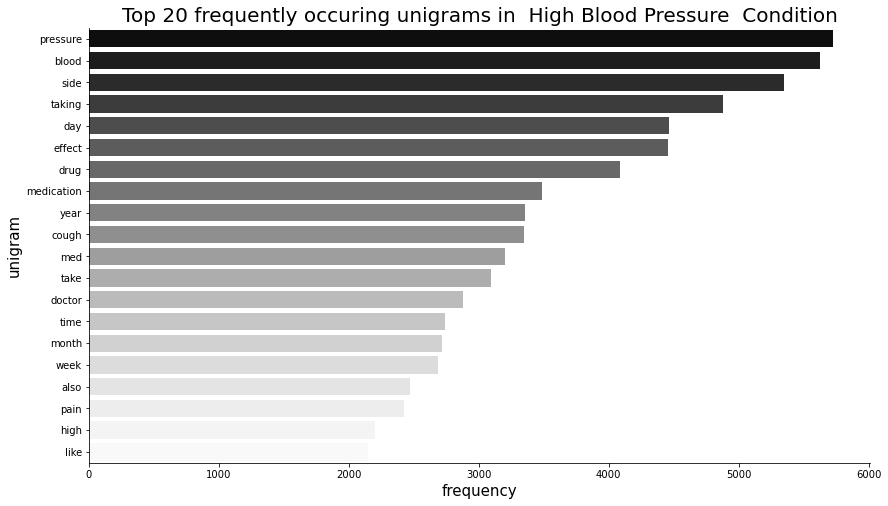

In [240]:
most_common = fdist_BP.most_common(20)
## Converting to Pandas series 
most_common = pd.Series(dict(most_common))
fig, ax = plt.subplots(figsize=(14,8))
BP_plot = sns.barplot(x=most_common.values, y=most_common.index,  ax=ax,palette='Greys_r',orient='h')
sns.despine()
plt.title('Top 20 frequently occuring unigrams in  High Blood Pressure  Condition', fontsize=20)
plt.ylabel('unigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

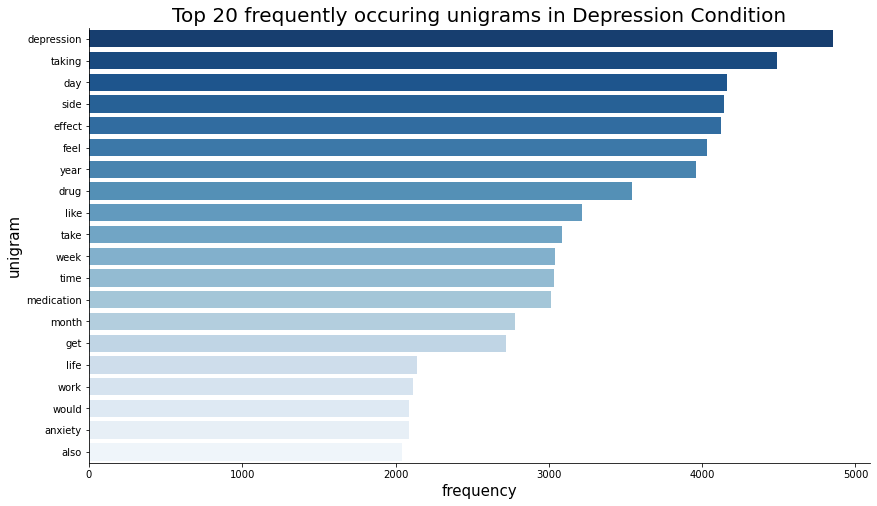

In [239]:
most_common = fdist_Depression.most_common(20)
## Converting to Pandas series 
most_common = pd.Series(dict(most_common))
fig, ax = plt.subplots(figsize=(14,8))
BP_plot = sns.barplot(x=most_common.values, y=most_common.index,  ax=ax,palette='Blues_r',orient='h')
sns.despine()
plt.title('Top 20 frequently occuring unigrams in Depression Condition', fontsize=20)
plt.ylabel('unigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

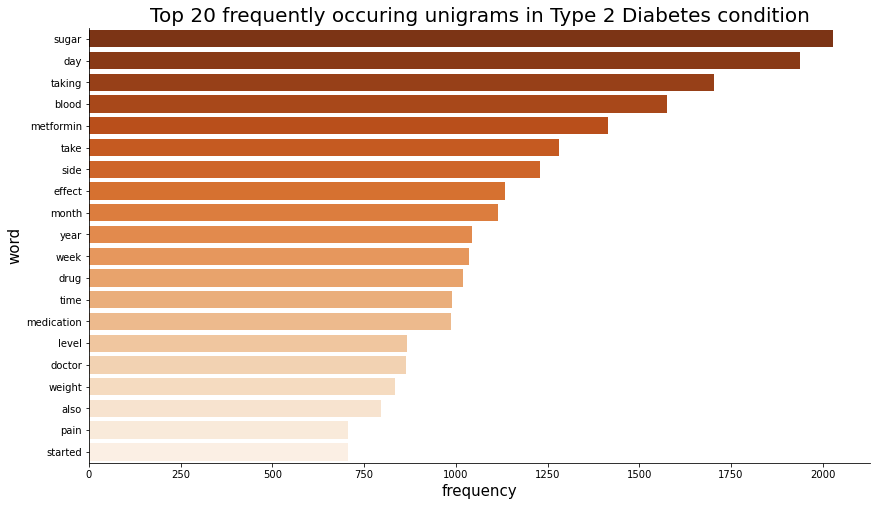

In [238]:
most_common = fdist_Diabetes.most_common(20)
## Converting to Pandas series 
most_common = pd.Series(dict(most_common))
fig, ax = plt.subplots(figsize=(14,8))
BP_plot = sns.barplot(x=most_common.values, y=most_common.index, ax=ax,orient='h',palette='Oranges_r')
sns.despine()
plt.title('Top 20 frequently occuring unigrams in Type 2 Diabetes condition',fontsize=20)
plt.ylabel('word',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

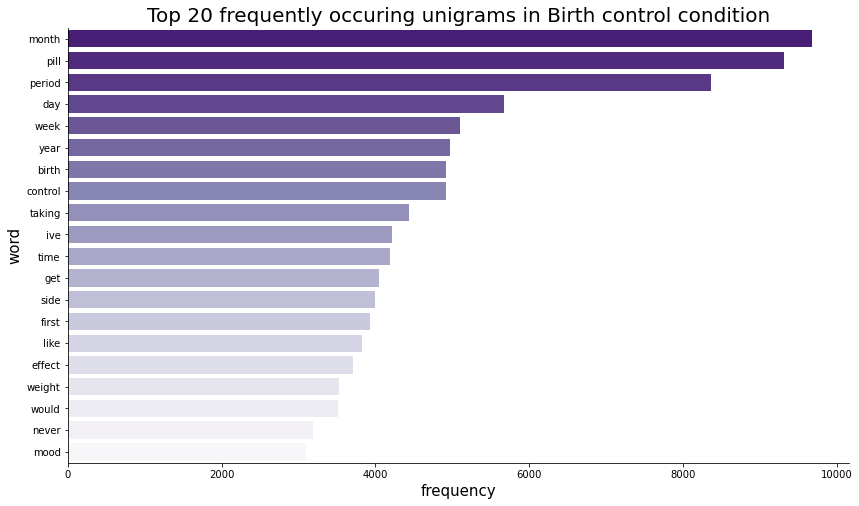

In [237]:
most_common = fdist_Birthcontrol.most_common(20)
## Converting to Pandas series 
most_common = pd.Series(dict(most_common))
fig, ax = plt.subplots(figsize=(14,8))
BP_plot = sns.barplot(x=most_common.values, y=most_common.index,ax=ax,palette='Purples_r',orient='h')
sns.despine()
plt.title('Top 20 frequently occuring unigrams in Birth control condition',fontsize=20)
plt.ylabel('word',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

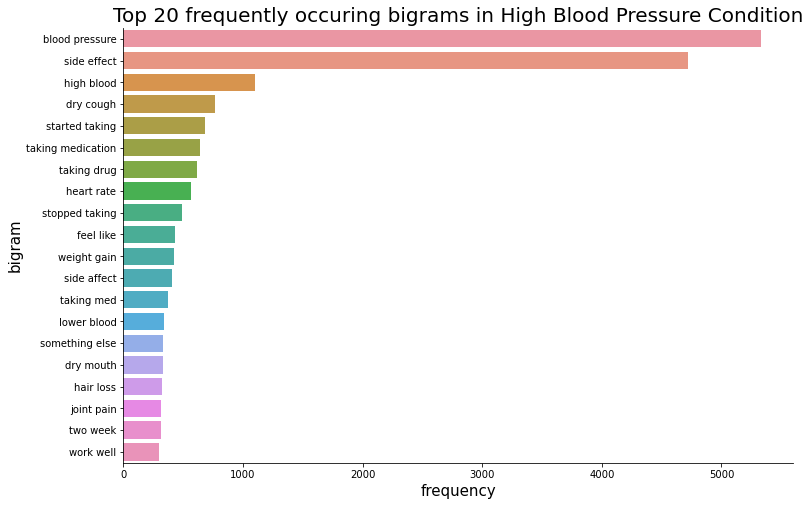

In [245]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def get_top_n_bigram(corpus, n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    BoW =  vectorizer.transform(corpus)
    sum_tokens = BoW.sum(axis=0) 
    token_freq = [(token, sum_tokens[0, idx]) for token, idx in vectorizer.vocabulary_.items()]
    token_freq =sorted(token_freq, key = lambda x: x[1], reverse=True)
    return token_freq[:n]

frequent_words = get_top_n_bigram(High_BP_Class['review_text'])

bigrams_BP = pd.DataFrame(frequent_words , columns = ['Review' , 'Count'])
plt.figure(figsize=(12,8))
sns.barplot(y=bigrams_BP.Review.values,x=bigrams_BP.Count.values,orient='h')
sns.despine()
plt.title('Top 20 frequently occuring bigrams in High Blood Pressure Condition', fontsize=20)
plt.ylabel('bigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

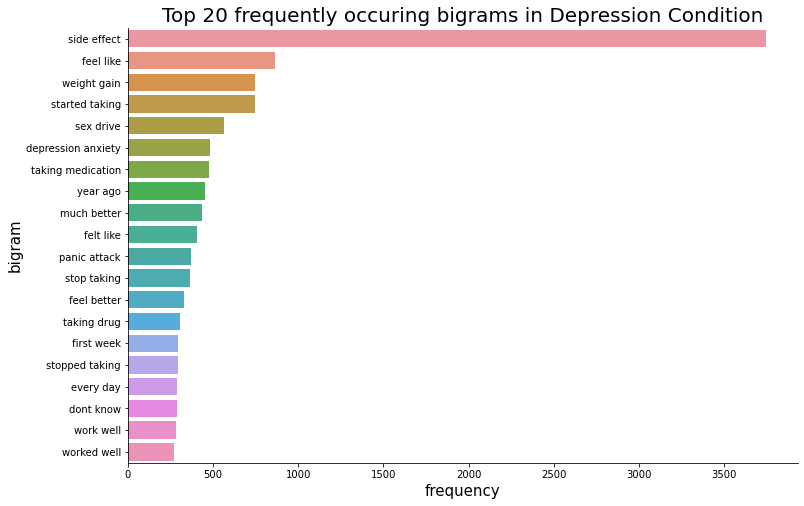

In [246]:
frequent_words = get_top_n_bigram(Depression_Class['review_text'])

bigrams_depression = pd.DataFrame(frequent_words , columns = ['Review' , 'Count'])
plt.figure(figsize=(12,8))
sns.barplot(y=bigrams_depression.Review.values,x=bigrams_depression.Count.values,orient='h')
sns.despine()
plt.title('Top 20 frequently occuring bigrams in Depression Condition', fontsize=20)
plt.ylabel('bigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

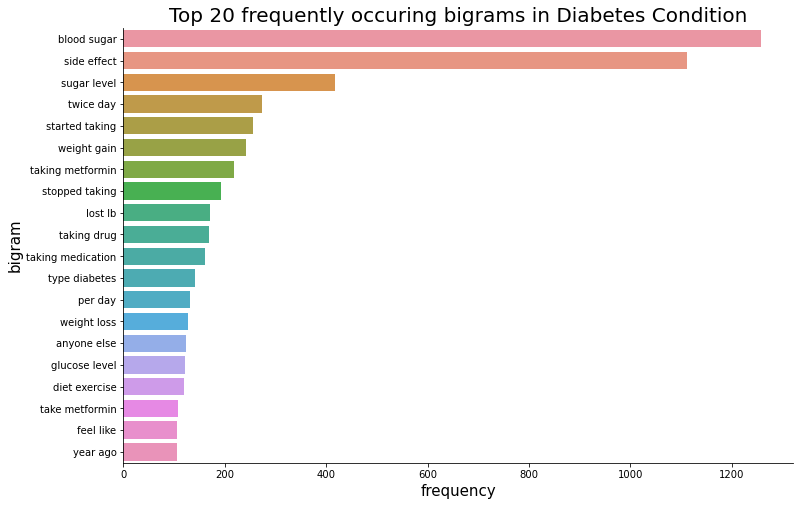

In [247]:
frequent_words = get_top_n_bigram(Diabetes_Class['review_text'])

bigrams_diabetes = pd.DataFrame(frequent_words , columns = ['Review' , 'Count'])
plt.figure(figsize=(12,8))
sns.barplot(y=bigrams_diabetes.Review.values,x=bigrams_diabetes.Count.values,orient='h')
sns.despine()
plt.title('Top 20 frequently occuring bigrams in Diabetes Condition', fontsize=20)
plt.ylabel('bigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

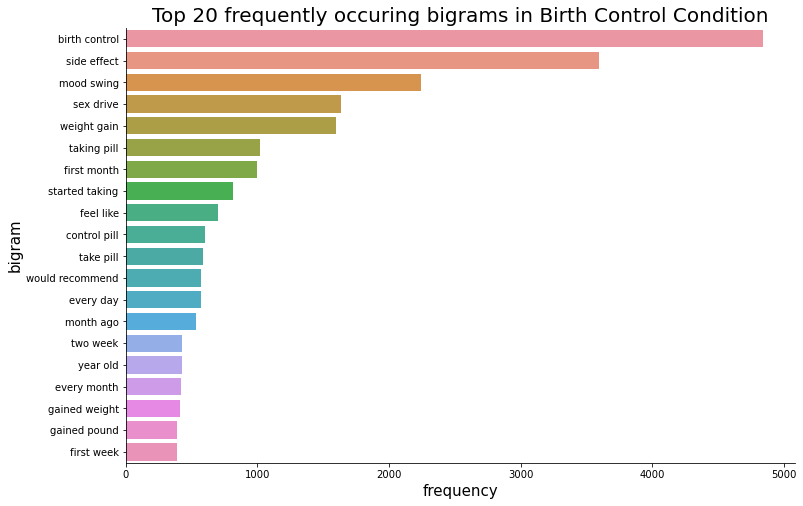

In [249]:
frequent_words = get_top_n_bigram(Birth_Control_Class['review_text'])

bigrams_birthcntrl = pd.DataFrame(frequent_words , columns = ['Review' , 'Count'])
plt.figure(figsize=(12,8))
sns.barplot(y=bigrams_birthcntrl.Review.values,x=bigrams_birthcntrl.Count.values,orient='h')
sns.despine()
plt.title('Top 20 frequently occuring bigrams in Birth Control Condition', fontsize=20)
plt.ylabel('bigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 0, 'frequency')

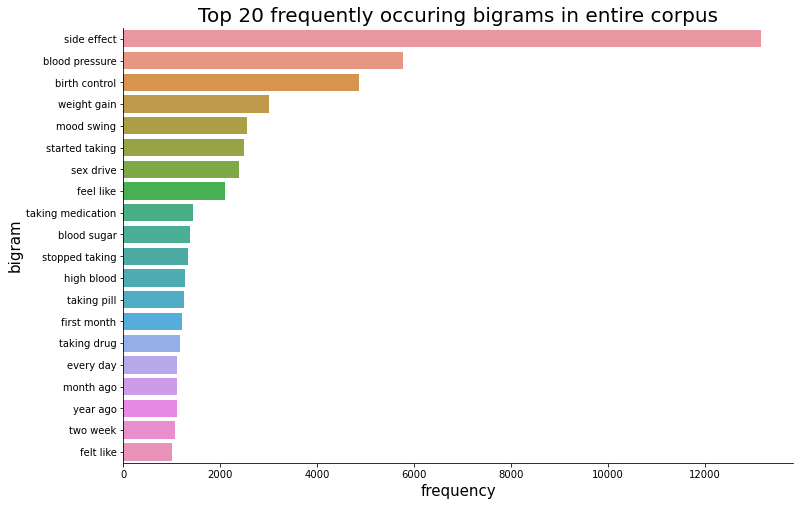

In [250]:
frequent_words = get_top_n_bigram(final_df['review_text'])

bigrams = pd.DataFrame(frequent_words , columns = ['Review' , 'Count'])
plt.figure(figsize=(12,8))
sns.barplot(y=bigrams.Review.values,x=bigrams.Count.values,orient='h')
sns.despine()
plt.title('Top 20 frequently occuring bigrams in entire corpus', fontsize=20)
plt.ylabel('bigram',fontsize=15)
plt.xlabel('frequency',fontsize=15)

Text(0.5, 1.0, 'Word cloud for whole corpus after pre-processing')

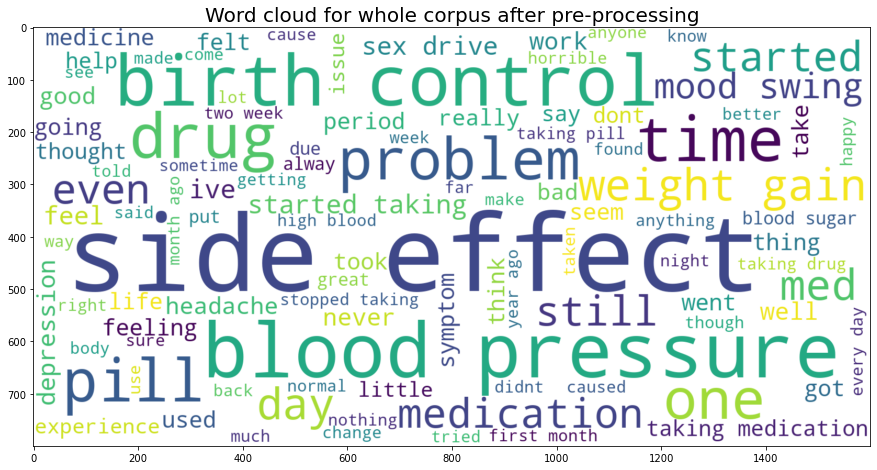

In [252]:
plt.figure(figsize=(15,20))

cloud = WordCloud(max_words = 100, 
                  width=1600, 
                  height=800,
                  background_color='white').generate(" ".join(final_df['review_text']))
plt.imshow(cloud, interpolation='bilinear')

plt.title('Word cloud for whole corpus after pre-processing',fontsize=20)